## phylogeny of global M. bovis lineages

* global https://www.frontiersin.org/articles/10.3389/fmicb.2020.00843/full

* UK https://www.ncbi.nlm.nih.gov/bioproject/PRJNA523164

In [351]:
import sys,os,shutil,subprocess
import glob,random
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
import seaborn as sns
from Bio import SeqIO
sys.path.append('pathogenie')
from snipgenie import tools, aligners, app, trees, plotting
import toytree

In [ ]:
from IPython.display import Image
Image(url='https://www.frontiersin.org/files/Articles/509125/fmicb-11-00843-HTML/image_m/fmicb-11-00843-g001.jpg',width=700)

In [44]:
brites=pd.read_csv('/storage/btbgenie/mbovis_other/mbovis_genomes_brites.csv')
brites[:3]

,Country,Host,SRA ID,References
0,Brazil,capybara,SRR9850824,This study
1,Brazil,llama,SRR9850830,This study
2,Brazil,bison,SRR7693912,This study


In [19]:
countries = list(brites.Country.unique())

In [115]:
sub1 = brites.Country.value_counts()[7:-1]
sub1
selected1 = brites[brites.Country.isin(sub1.index)]

## sub-sample countries with many entries

In [129]:
sub2 = brites.Country.value_counts()[:7]
s2 = brites[brites.Country.isin(sub2.index)]
selected2=s2.groupby('Country').sample(2,random_state=2) 

## fetch data

In [ ]:
omit = ['SRR7693877','SRR7693912','SRR9850830','SRR5486090','SRR5486092']
for sra in selected2['SRA ID']:
    print (sra)
    if sra in omit:
        continue
    f = glob.glob('/storage/btbgenie/mbovis_other/%s*.fastq*' %sra)
    if len(f)>0:
        continue
    cmd = 'fastq-dump --split-files -O /storage/btbgenie/mbovis_other %s' %sra
    subprocess.check_output(cmd, shell=True)
    cmd = 'pigz /storage/btbgenie/mbovis_other/%s*.fastq' %sra
    print (cmd)
    subprocess.check_output(cmd, shell=True)

In [ ]:
reload(app)
args = {'threads':20, 'outdir': '/storage/btbgenie/global_results', 'labelsep':'-',
        'input':['/storage/btbgenie/mbovis_other'],
         'species': 'Mbovis-AF212297', 'overwrite':False,
         'custom_filters': True,        
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

## merge meta data

In [221]:
samples = W.fastq_table
samples = samples.merge(brites,left_on='sample',right_on='SRA ID',how='left')
samples = samples.drop_duplicates('sample')

## spoligotypes

In [ ]:
def get_spoligotypes(samples):
    """Get spoligotypes for M.bovis strains"""
    
    samples = samples.drop_duplicates('sample')
    res=[]
    for i,r in samples.iterrows():       
        f=r.filename
        b = tools.get_spoligotype(f,1e6)
        sb = tools.get_sb_number(b)
        print (r['sample'],f, sb, b)
        res.append([r['sample'],f,sb,b])
    
    res = pd.DataFrame(res,columns=['sample','filename','SB','code'])
    return res

spotypes = get_spoligotypes(samples)
spotypes.to_csv('/storage/btbgenie/global_results/spotypes.csv')

In [561]:
spotypes = pd.read_csv('/storage/btbgenie/global_results/spotypes.csv')
#spotypes['SB'] = spotypes.SB.fillna('-)
samples = samples.merge(spotypes,on='sample')
meta = brites.merge(spotypes,left_on='SRA ID',right_on='sample')

In [370]:
tre.get_tip_labels()[:3]

['SRR5486072', 'SRR5486071', 'SRR5486076']

In [ ]:
treefile = '/storage/btbgenie/global_results/RAxML_bipartitions.variants'
tre = toytree.tree(treefile)
tre=tre.drop_tips(['SRR5486090', 'SRR5486092', 'SRR5486091', 'ref'])
mystyle = { "layout": 'r','node_sizes':1,'tip_labels_align':True}
tre.draw(**mystyle,width=700);

In [356]:
tre = tre.root(names=['SRR5486072'])
tipnames = tre.get_tip_labels()
mapping = dict(zip(samples['sample'],samples.Country))
mapping['ref'] = 'AF2122/97'
tiplabels = [mapping[i] for i in tipnames]
mapping = dict(zip(samples['sample'],samples.SB))
colormap = trees.colors_from_labels(samples,'sample','SB')
tip_colors = [colormap[mapping[i]] if i in mapping else 'Black' for i in tipnames]
node_sizes=[0 if i else 8 for i in tre.get_node_values(None, 1, 0)]
node_colors = [colormap[mapping[n]] if n in mapping else 'black' for n in tre.get_node_values('name', True, True)]

canvas,t,r=tre.draw(layout='r',width=600,height=700,tip_labels=tiplabels,node_markers="o",node_hover=True,edge_widths=1,
         tip_labels_colors=tip_colors,node_sizes=node_sizes,scalebar=True,node_colors=node_colors)#tip_labels_align=True);


leg = list(zip(tiplabels,colors))
#print (leg)
#canvas.legend(leg,corner=("top", 100, 100, 70));

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="600.0px" height="700.0px" viewBox="0 0 600.0 700.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t183fefc7de924939b423ad61c43dccbd"> idx: 0
dist: 0.0072
support: 0.0000
height: 0.0453
name: SRR5216864 idx: 1
dist: 0.0088
support: 0.0000
height: 0.0437
name: SRR6467891 idx: 2
dist: 0.0003
support: 0.0000
height: 0.0419
name: ERR841833 idx: 3
dist: 0.0003
support: 0.0000
height: 0.0419
name: ERR841811 idx: 4
dist: 0.0101
support: 0.0000
height: 0.0459
name: SRR6045214 idx: 5
dist: 0.0034
support: 0.0000
height: 0.0511
name: SRR6467885 idx: 6
dist: 0.0053
support: 0.0000
height: 0.0492
name: SRR7240264 idx: 7
dist: 0.0085
support: 0.0000
height: 0.0473
name: SRR7240109 idx: 8
dist: 0.0075
support: 0.0000
height: 0.0483
name: SRR1791709 idx: 9
dist: 0.0117
support: 0.0000
height: 0.0465
name: SRR5430746 idx: 10
dist: 0.0101
support: 0.0000
height: 0.0483
name: SRR6467893 idx: 11
dist: 0.0082
support: 0.0000
height: 0.0502
name: SRR6045806 idx: 12
dist: 0.0053
support: 0.0000
height: 0.0444
name: SRR5817677 idx: 13
dist: 0.0041
support: 0.0000
height: 0.0457
name: SRR1657070 idx: 14
dist: 0.0056
support: 0.0000
height: 0.0472
name: SRR5657474 idx: 15
dist: 0.0150
support: 0.0000
height: 0.0414
name: SRR5430098 idx: 16
dist: 0.0000
support: 0.0000
height: 0.0503
name: SRR1657068 idx: 17
dist: 0.0000
support: 0.0000
height: 0.0503
name: SRR1657061 idx: 18
dist: 0.0130
support: 0.0000
height: 0.0499
name: SRR6467887 idx: 19
dist: 0.0012
support: 0.0000
height: 0.0490
name: SRR5430747 idx: 20
dist: 0.0025
support: 0.0000
height: 0.0478
name: SRR5430750 idx: 21
dist: 0.0012
support: 0.0000
height: 0.0490
name: SRR5430569 idx: 22
dist: 0.0272
support: 0.0000
height: 0.0427
name: ERR564390 idx: 23
dist: 0.0352
support: 0.0000
height: 0.0504
name: SRR5196685 idx: 24
dist: 0.0006
support: 0.0000
height: 0.0507
name: ERR1815541 idx: 25
dist: 0.0016
support: 0.0000
height: 0.0497
name: ERR1815549 idx: 26
dist: 0.0091
support: 0.0000
height: 0.0510
name: ERR550954 idx: 27
dist: 0.0000
support: 0.0000
height: 0.0461
name: SRR1791768 idx: 28
dist: 0.0003
support: 0.0000
height: 0.0458
name: SRR6467889 idx: 29
dist: 0.0130
support: 0.0000
height: 0.0443
name: SRR9850824 idx: 30
dist: 0.0124
support: 0.0000
height: 0.0448
name: SRR6705904 idx: 31
dist: 0.0120
support: 0.0000
height: 0.0482
name: ERR551917 idx: 32
dist: 0.0128
support: 0.0000
height: 0.0474
name: ERR551009 idx: 33
dist: 0.0347
support: 0.0000
height: 0.0520
name: ERR550755 idx: 34
dist: 0.0166
support: 0.0000
height: 0.0433
name: ERR502526 idx: 35
dist: 0.0204
support: 0.0000
height: 0.0394
name: ERR502499 idx: 36
dist: 0.0000
support: 0.0000
height: 0.0470
name: ERR2659160 idx: 37
dist: 0.0000
support: 0.0000
height: 0.0470
name: ERR2659159 idx: 38
dist: 0.0223
support: 0.0000
height: 0.0443
name: ERR1203064 idx: 39
dist: 0.0240
support: 0.0000
height: 0.0425
name: ERR553061 idx: 40
dist: 0.0071
support: 0.0000
height: 0.0000
name: ERR161044 idx: 41
dist: 0.0032
support: 0.0000
height: 0.0039
name: ERR181980 idx: 42
dist: 0.0380
support: 0.0000
height: 0.0491
name: ERR229952 idx: 43
dist: 0.0369
support: 0.0000
height: 0.0502
name: ERR551252 idx: 44
dist: 0.0003
support: 0.0000
height: 0.0534
name: SRR1791710 idx: 45
dist: 0.0000
support: 0.0000
height: 0.0537
name: SRR1791712 idx: 46
dist: 0.0000
support: 0.0000
height: 0.0946
name: ERR2659161 idx: 47
dist: 0.0000
support: 0.0000
height: 0.0946
name: ERR2659162 idx: 48
dist: 0.0063
support: 0.0000
height: 0.0971
name: SRR7131117 idx: 49
dist: 0.0009
support: 0.0000
height: 0.1060
name: SRR7131025 idx: 50
dist: 0.0191
suppor

## combine ireland + global samples in one tree

use subset of the Ireland samples to include in global tree

In [211]:
mapped = {'wicklow':'/storage/btbgenie/wicklow_results/mapped/',
           'monaghan':'/storage/btbgenie/monaghan/monaghan_results/mapped/',
           'NI':'/storage/btbgenie/NI_results/','global':'/storage/btbgenie/global_results/'}
reload(app)
bam_files=[]
for m in mapped:
    f = app.get_files_from_paths(mapped[m], '*.bam')
    #get sub-sample
    if m != 'global':
        f = random.sample(f,8)
    bam_files.extend(f)
print (len(bam_files))
outdir='/storage/btbgenie/combined_results'


84


'/storage/btbgenie/combined_results/samples.txt'

## run variant calling only on already mapped files

In [ ]:
gff_file=os.path.join(outdir,'mbovis.gff')
tools.gff_bcftools_format(app.mbovis_gb, gff_file)
app.run_bamfiles(bam_files, app.mbovis_genome, outdir='/storage/btbgenie/combined_results', threads=20,
                 mask=app.mbovis_mask, gff_file=gff_file,
                 custom_filters=True, overwrite=False)

In [214]:
treefile = '/storage/btbgenie/combined_results/RAxML_bipartitions.variants'
tre2 = toytree.tree(treefile)

In [ ]:
tre2.ladderize().draw(**mystyle,width=700);

## RD analysis

In [ ]:
from snipgenie import rdiff
rdiff.create_rd_index()
df = W.fastq_table
res = rdiff.find_regions(df,'/storage/btbgenie/global_results/rd_aligned',threads=20)

In [ ]:
X = rdiff.get_matrix(res, cutoff=0.15)
X['ident'] = X.apply(rdiff.apply_rules,1)
#plotting.heatmap(X.set_index('ident',append=True), h=8, cmap='cubehelix')
X.to_csv('/storage/btbgenie/global_results/rd.csv')
X[:4]
cols=['SRA ID','Country','SB']
X=X.merge(meta[cols],left_index=True,right_on='SRA ID').set_index(cols)

sns.clustermap(X.iloc[:,:-1],xticklabels=True,yticklabels=True,figsize=(12,12))
rvar = ['RD149','RD3','RD5','RD5oryx*','RD122']

rdv = X[rvar]


In [570]:
names = tre.get_tip_labels()
names.reverse()
matrix = rdv.loc[names].values*255

In [571]:
# create a canvas
import toyplot
canvas = toyplot.Canvas(width=600, height=650);

# add tree
axes = canvas.cartesian(bounds=(50, 350, 20, 640))
tre.draw(axes=axes,node_colors=node_colors, #,tip_labels=tiplabels
         tip_labels_colors=tip_colors,node_sizes=node_sizes, tip_labels_align=True)

# add matrix
table = canvas.table(
    rows=len(rdv),
    columns=5,
    margin=0,
    bounds=(375, 450, 25, 630),  
)

colormap = toyplot.color.brewer.map("Blues")

# apply a color to each cell in the table
for ridx in range(matrix.shape[0]):
    for cidx in range(matrix.shape[1]):
        cell = table.cells.cell[ridx, cidx]
        cell.style = {
            "fill": colormap.colors(matrix[ridx, cidx], 0, 100),
        }

# style the gaps between cells
table.body.gaps.columns[:] = 3
table.body.gaps.rows[:] = 3

# hide axes coordinate



<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="600.0px" height="650.0px" viewBox="0 0 600.0 650.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t2a5808b942e44336a7d396bcb8eb76a1"> SRR5486072 SRR5486071 SRR5486076 SRR3085259 SRR5486088 SRR5486087 SRR5486089 SRR5486093 SRR4117155 SRR5486077 ERR2659161 ERR2659162 SRR7131117 SRR7131025 SRR1791710 SRR1791712 ERR229952 ERR551252 ERR161044 ERR181980 ERR502526 ERR502499 ERR2659160 ERR2659159 ERR1203064 ERR553061 ERR1815541 ERR1815549 ERR550954 SRR1791768 SRR6467889 SRR9850824 SRR6705904 ERR551917 ERR551009 ERR550755 SRR5196685 SRR5817677 SRR1657070 SRR5657474 SRR5430098 SRR1657068 SRR1657061 SRR6467887 SRR5430747 SRR5430750 SRR5430569 ERR564390 SRR6467893 SRR6045806 SRR6467885 SRR7240264 SRR7240109 SRR1791709 SRR5430746 SRR5216864 SRR6467891 ERR841833 ERR841811 SRR6045214 -0.15 -0.10 -0.05 0.00 0.05 0 20 40 60

## SNPs and indels matrix

In [522]:
c = app.read_csq_file('/storage/btbgenie/global_results/csq.tsv')
snp_mat = app.get_aa_snp_matrix(c)

In [587]:
ind = app.read_csq_file('/storage/btbgenie/global_results/csq_indels.tsv')
ind_mat = app.get_aa_snp_matrix(c)
ind_mat.index = ind_mat.index.get_level_values(1)+'_'+ind_mat.index.get_level_values(2)
stat = ind_mat.sum(1).reset_index()
#stat.gene.value_counts()[:30]

In [592]:
C=ind_mat.T
C=C.merge(meta[cols],left_index=True,right_on='SRA ID').set_index(cols).T

In [593]:
C=C[C.sum(1)>3].T
#print (C[:4])
countries = C.index.get_level_values(1)
sb = C.index.get_level_values(2)

Index(['SB2277', 'SB2277', 'SB0121', 'SB0121', 'SB2277', 'SB2277', 'SB0944', 'SB0944', 'SB0120', 'SB0120', 'SB2277', 'SB2277', 'SB0871', 'SB0339',      nan, 'SB0288',      nan, 'SB0944', 'SB2277',
       'SB0140', 'SB0140', 'SB1041', 'SB1041', 'SB0145', 'SB0673', 'SB2467', 'SB2467', 'SB0265', 'SB0120', 'SB0120', 'SB0821', 'SB0140', 'SB0145', 'SB0130', 'SB1072', 'SB0130', 'SB0130', 'SB1517',
       'SB1517', 'SB0134', 'SB0120', 'SB0120', 'SB0120', 'SB0828', 'SB0828', 'SB0828', 'SB0828', 'SB0828', 'SB0145', 'SB0145', 'SB0263', 'SB0267', 'SB0673', 'SB0130', 'SB0265', 'SB0140', 'SB1071',
       'SB0121', 'SB0120', 'SB0120', 'SB0673', 'SB2374', 'SB0295'],
      dtype='object', name='SB')


['blue', 'blue', 'green', 'green', 'blue', 'blue', 'crimson', 'crimson', 'blueviolet', 'blueviolet', 'blue', 'blue', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'cadetblue', 'crimson', 'blue', 'chocolate', 'chocolate', 'coral', 'coral', 'gold', 'cornflowerblue', 'cornsilk', 'cornsilk', 'khaki', 'blueviolet', 'blueviolet', 'orange', 'chocolate', 'gold', 'pink', 'red', 'pink', 'pink', 'lime', 'lime', 'mediumvioletred', 'blueviolet', 'blueviolet', 'blueviolet', 'navy', 'navy', 'navy', 'navy', 'navy', 'gold', 'gold', 'teal', 'darkblue', 'cornflowerblue', 'pink', 'khaki', 'chocolate', 'purple', 'green', 'blueviolet', 'blueviolet', 'cornflowerblue', 'orange', 'salmon']


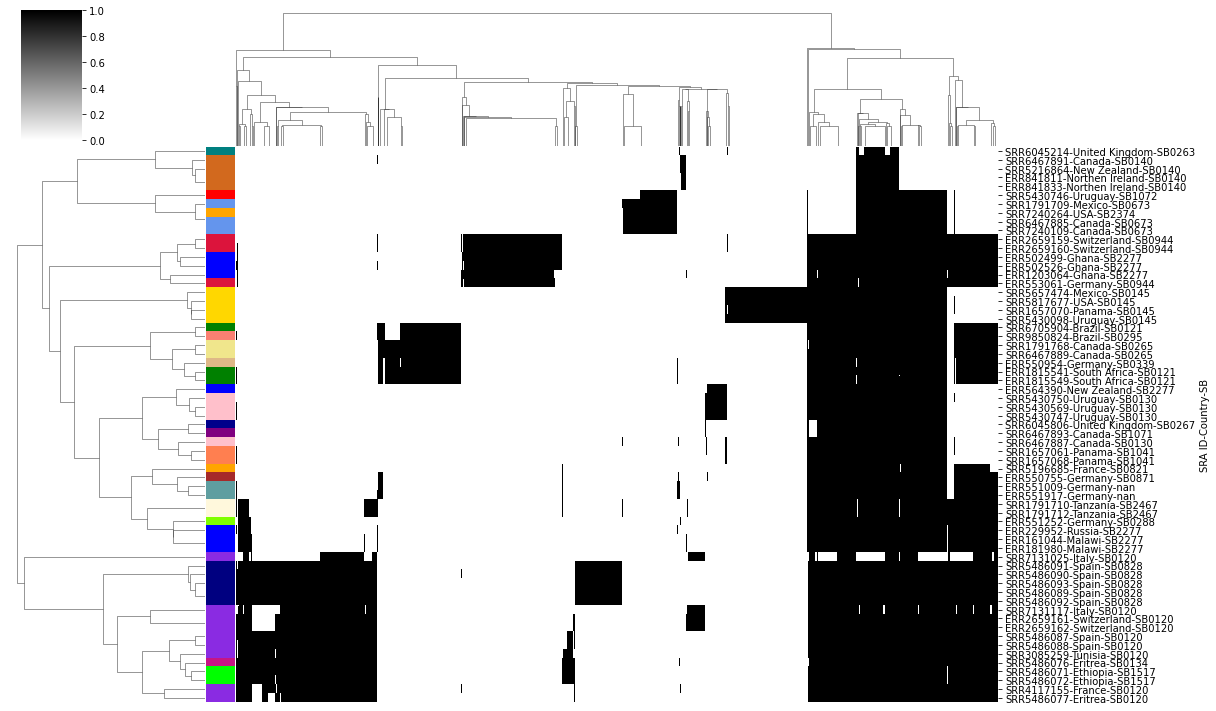

In [596]:
reload(trees)
colormap = dict(zip(sb.unique(), trees.qcolors))
row_colors = [colormap[i] if i in colormap else 'Black' for i in sb]
#print (row_colors)
sns.clustermap(C,xticklabels=False,yticklabels=True,figsize=(17,10),cmap='gray_r',row_colors=row_colors)


## PCA snps

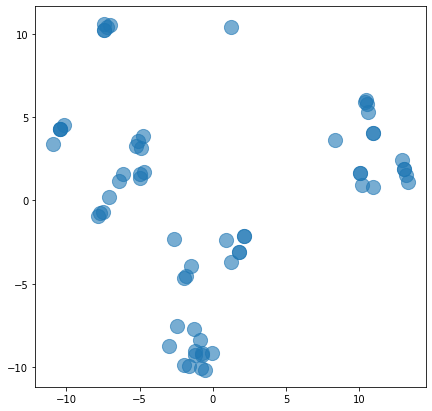

In [541]:
import sklearn
from sklearn import decomposition
from sklearn import manifold

pca = decomposition.PCA(n_components=3)
mds = manifold.MDS(n_components=3)
pos = mds.fit(C).embedding_
X = pca.fit_transform(pos)

#X = pca.transform(C)

fig,ax = plt.subplots(figsize=(7, 7))
#y = df.color
ax.scatter(X[:, 0], X[:, 1], s=200, alpha=.6)